Inspired by **CNN Exercise - Deep Learning for Computer Vision** on [Kaggle](https://www.kaggle.com/code/mgmarques/cnn-exercise-deep-learning-for-computer-vision) 

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from trainers import ClassifierTrainer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random

In [2]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = torch.tensor(self.data_dict[b'data'].reshape(-1,3,32,32))/255
        self.labels = torch.tensor(self.data_dict[b'labels'])
        
    def __getitem__(self,index):
        # Get one item from the dataset
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
def show_sample_image(dataset, idx=0, add_title=True, ax=None):
    image, label = dataset[idx]
    label = label.item()
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    label_name = dataset.class_names[label]
    if ax is None:
        _, ax = plt.subplots(figsize=(1,1))
    ax.imshow(flipped_image, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if add_title:
        ax.set_title(label_name)
    return flipped_image, label, label_name, ax

In [4]:
class CIFARCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=8192, out_features=1024)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)
    
    def init_model_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        
    def forward(self,x):
        
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        out = out.view(-1,8192)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        
        return out

# Setup the datasets

In [5]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 100

In [6]:
train_dataset = CIFARDataset(path_data, train_batches)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

# Train the mdel

In [7]:
#Initialize the model
model = CIFARCNN()
#Define the optimizer
optimizer = torch.optim.Adadelta(model.parameters(), lr = 0.01)
#Number of pochs
num_epochs = 100

In [8]:
trainer = ClassifierTrainer(model, optimizer,
                            train_loader, test_loader)

In [9]:
%%time
trainer.fit(num_epochs)

Epoch 1/100, Training Loss: 1.657, Training Accuracy: 0.412, Testing Loss: 1.382, Testing Acc: 0.515
Epoch 2/100, Training Loss: 1.345, Training Accuracy: 0.523, Testing Loss: 1.231, Testing Acc: 0.563
Epoch 3/100, Training Loss: 1.202, Training Accuracy: 0.577, Testing Loss: 1.125, Testing Acc: 0.604
Epoch 4/100, Training Loss: 1.101, Training Accuracy: 0.613, Testing Loss: 1.038, Testing Acc: 0.639
Epoch 5/100, Training Loss: 1.026, Training Accuracy: 0.643, Testing Loss: 0.991, Testing Acc: 0.655
Epoch 6/100, Training Loss: 0.964, Training Accuracy: 0.663, Testing Loss: 0.959, Testing Acc: 0.660
Epoch 7/100, Training Loss: 0.915, Training Accuracy: 0.683, Testing Loss: 0.925, Testing Acc: 0.681
Epoch 8/100, Training Loss: 0.877, Training Accuracy: 0.696, Testing Loss: 0.900, Testing Acc: 0.692
Epoch 9/100, Training Loss: 0.843, Training Accuracy: 0.707, Testing Loss: 0.880, Testing Acc: 0.691
Epoch 10/100, Training Loss: 0.808, Training Accuracy: 0.721, Testing Loss: 0.857, Testing 

Epoch 82/100, Training Loss: 0.042, Training Accuracy: 0.993, Testing Loss: 0.897, Testing Acc: 0.760
Epoch 83/100, Training Loss: 0.040, Training Accuracy: 0.994, Testing Loss: 0.906, Testing Acc: 0.757
Epoch 84/100, Training Loss: 0.038, Training Accuracy: 0.994, Testing Loss: 0.923, Testing Acc: 0.756
Epoch 85/100, Training Loss: 0.036, Training Accuracy: 0.995, Testing Loss: 0.910, Testing Acc: 0.758
Epoch 86/100, Training Loss: 0.036, Training Accuracy: 0.994, Testing Loss: 0.928, Testing Acc: 0.755
Epoch 87/100, Training Loss: 0.034, Training Accuracy: 0.995, Testing Loss: 0.922, Testing Acc: 0.758
Epoch 88/100, Training Loss: 0.034, Training Accuracy: 0.995, Testing Loss: 0.921, Testing Acc: 0.756
Epoch 89/100, Training Loss: 0.033, Training Accuracy: 0.995, Testing Loss: 0.921, Testing Acc: 0.760
Epoch 90/100, Training Loss: 0.032, Training Accuracy: 0.995, Testing Loss: 0.941, Testing Acc: 0.760
Epoch 91/100, Training Loss: 0.032, Training Accuracy: 0.995, Testing Loss: 0.925,

In [10]:
model_file = './models/cifar10_cnn_v1_270822'
trainer.save_model(model_file)

# Model Evaluation

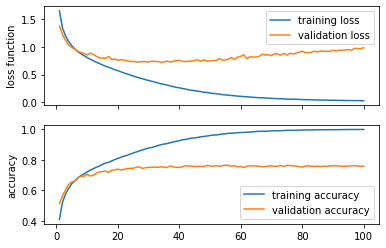

In [11]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

# Visualize predictions

accuracy for the presented 25 images: 0.8


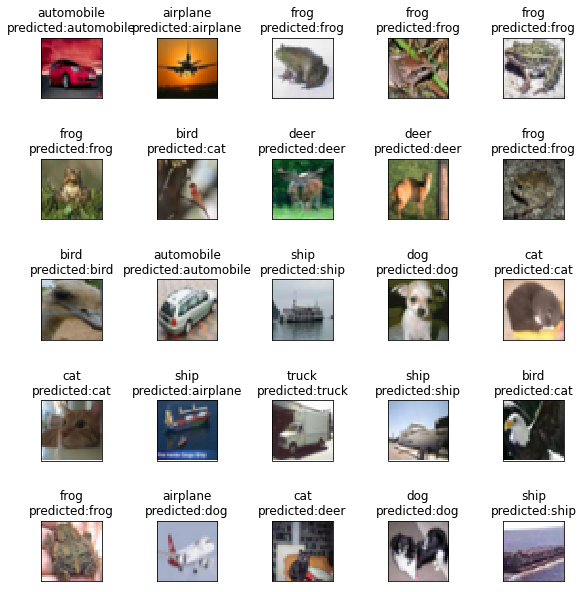

In [12]:
dataset = test_dataset

nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))

accuracy = 0

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(dataset)-1)
        prediction = trainer.predict(dataset, idx)
        prediction_name = dataset.class_names[prediction]
        _, label, label_name, ax = show_sample_image(dataset, idx,ax=axs[i,j], add_title=False)
        ax.set_title(label_name + '\npredicted:' + prediction_name)
        plt.subplots_adjust(hspace=1)
        accuracy +=1/(nrows*ncols)*float(prediction==label)
        
print('accuracy for the presented '+str(nrows*ncols)+' images: '+str(round(accuracy,2)))